# Machine Learning II - Urban Sound Classification with Neural Networks

Trabalho realizado pelos alunos Francisco Macieira (202207166), Gabriela Simon (202200209) e Noa Santos (202201392)

Neste projeto, trabalhamos com um dataset de sons urbanos. Cada áudio pertence a uma das seguintes classes: ar condicionado, buzina de carro, crianças a brincar, latido de cachorro, perfuração, motor em marcha lenta, tiro de arma, britadeira, sirene e música de rua. O projeto tem como objetivo implementar dois classificadores de deep learning para classificar os sons. Os modelos escolhidos foram um Multi Layer Perceptron (MLP) e uma Rede Neural Convolucional (CNN)  
Nota: Nem todo o código está corrido no notebook porque as runs estavam espalhadas por vários notebooks, mas todos os resultados e datasets estão guardados em ficheiros e foram entregues com o trabalho

## Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
from glob import glob
import librosa
import numpy as np
import librosa
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import optuna
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Pré processamento de Dados para o Multi Layer Perceptron

O pre processamento dos dados para trabalhar com o Multi Layer Perceptron consiste em uma extração de features que são salvas num CSV, que vai ser usado com o modelo MLP

In [ ]:
audio_files = glob('UrbanSound8K/audio/*/*.wav')

#### Ajuste da duração dos audios para 4 segundos

In [ ]:
def uniform_duration(sr, audio):
    target_length = 4 * sr

    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        audio = audio[:target_length]
    return audio

durations = []

for i in range(len(audio_files)):
    audio, _ = librosa.load(audio_files[i])
    audio = uniform_duration(22050, audio)

    duration = len(audio) / 22050

    durations.append({
        "file_name": f"audio_{i}",

        "duration_seconds": duration
    })

df_durations = pd.DataFrame(durations)

#### Normalização dos audios para que todos estejam no mesmo intervalo

In [ ]:
for i in range(len(audio_files)):
    audio, _ = librosa.load(audio_files[i])
    audio = audio / np.max(np.abs(audio))  # Normalização para [-1, 1]

#### Extração de features

As features extraidas foram:
- MFCCs: Mel-frequency cepstral coefficients, informações espectrais perceptuais;
- Chroma: energia do audio distribuida em 12 classes de pitch;
- Spectral Contrast: diferença entre picos e vales no espectro;
- Tonnetz: caracteristicas tonais, como harmonia e consoância;
- Zero Crossing Rate: taxa de mudanças de sinal;
- Root Mean Square Energy: energia do audio em janelas de tempo;
- Spectral Rolloff: ponto no espectro onde uma porcentagem da energia total está abaixo;
- Spectral Centroid: localização do "centro de massa" do espectro;
- Spectral Bandwidth: largura do espectro em torno do seu centro;
- Mel Spectogram: energia em bandas de frequencia de Mel.

In [ ]:
def extract_features(audio_file):
    audio, sr = librosa.load(audio_file)

    n_fft = 1024
    if len(audio) < 1024: # Ajuste so comprimento do audio para evitar erros nos calculos
        n_fft = 256

    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=1, n_fft=n_fft)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=n_fft)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=n_fft)
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(audio)

    rmse = librosa.feature.rms(y=audio)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, n_fft=n_fft, roll_percent=0.85)
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, n_fft=n_fft)
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, n_fft=n_fft)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr,  n_fft=n_fft)

    fold = next(part for part in audio_file.split(os.sep) if "fold" in part)

    file_id = os.path.basename(audio_file).split('.')[0]
    features = [
        file_id, fold,
        np.mean(mfccs), np.std(mfccs),
        np.mean(chroma), np.std(chroma),
        np.mean(spectral_contrast), np.std(spectral_contrast),
        np.mean(tonnetz), np.std(tonnetz),
        np.mean(zero_crossing_rate), np.std(zero_crossing_rate),
        np.mean(rmse), np.std(rmse),
        np.mean(spectral_rolloff), np.std(spectral_rolloff),
        np.mean(centroid), np.std(centroid),
        np.mean(bandwidth), np.std(bandwidth),
        np.mean(mel_spectrogram), np.std(mel_spectrogram)
    ]

    return features

In [ ]:
def feature_extraction(audio_files, features_list, columns):
    i = 0
    for file_path in audio_files:
        features = extract_features(file_path)
        features_list.append(features)
        i+=1
        if (i%100)==0:
            print(f"{i} iterações realizadas")


    if not features_list or len(features_list[0]) != len(columns):
        raise ValueError(f"Features list não corresponde ao número de colunas. "
                         f"Esperado {len(columns)}, mas encontrou {len(features_list[0])}.")


    df = pd.DataFrame(features_list, columns=columns)
    df.to_csv("feature_extraction.csv", index=False) # Salva a extração de features em um CSV

In [ ]:
columns = [
    "file_id", "fold",
    "mfcc_mean", "mfcc_std",
    "chroma_mean", "chroma_std",
    "spectral_contrast_mean", "spectral_contrast_std",
    "tonnetz_mean", "tonnetz_std",
    "zero_crossing_rate_mean", "zero_crossing_rate_std",
    "rmse_mean", "rmse_std",
    "spectral_rolloff_mean", "spectral_roloff_std",
    "centroid_mean", "centroid_std",
    "bandwidth_mean", "bandwidth_std",
    "contrast_mean", "contrast_std",
    "mel_spectrogram_mean", "mel_spectrogram_std"
]

features_list = []

feature_extraction(audio_files, features_list, columns)

#### Adição da coluna de classe ao CSV

In [ ]:
def add_target_column(features_csv, target_csv):
    target_csv = pd.read_csv(target_csv)
    features_csv = pd.read_csv(features_csv)
    target_csv['file_id'] = target_csv['slice_file_name'].str.replace(".wav", "", regex=False)
    merged_csv = pd.merge(features_csv, target_csv[['file_id', 'salience', 'class']], on="file_id", how="left")
    merged_csv.to_csv("feature_extraction.csv", index=False)
    return merged_csv

In [ ]:
features_csv = 'feature_extraction.csv'
target_csv = 'UrbanSound8K/metadata/UrbanSound8K.csv'
csv_file = add_target_column(features_csv, target_csv)

---

## Multi Layer Perceptron

#### Divisão dos dados em X e Y


Label Encoder do y & Normalização do X

In [84]:
dataset_path = 'feature_extraction.csv'
data = pd.read_csv(dataset_path)

X = data.drop(columns=['file_id', 'class', 'fold'])
y = data['class']

#One Hot Encoder de y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#Normalização de X
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(pd.DataFrame(X).head())
print(np.unique(y))

         0         1         2         3         4         5         6   \
0  0.683183  0.017093  0.621973  0.469777  0.383277  0.638431  0.505458   
1  0.718800  0.105597  0.460109  0.637143  0.377176  0.563590  0.472180   
2  0.728638  0.092748  0.416206  0.685898  0.283718  0.519607  0.469577   
3  0.478898  0.036833  0.516766  0.653926  0.260736  0.470929  0.489646   
4  0.496398  0.700244  0.422515  0.824047  0.313228  0.513074  0.495865   

         7         8         9   ...        13        14        15        16  \
0  0.035471  0.092136  0.036746  ...  0.077481  0.165125  0.026641  0.279333   
1  0.138060  0.186574  0.273884  ...  0.395330  0.385121  0.297618  0.668237   
2  0.104300  0.098335  0.046947  ...  0.325160  0.241995  0.111223  0.464770   
3  0.139243  0.087479  0.104135  ...  0.125955  0.218403  0.084630  0.418222   
4  0.135814  0.168407  0.233478  ...  0.402947  0.331131  0.254352  0.459972   

         17        18        19        20        21   22  
0  0.0266

#### Definição dos folds de acordo com os folds dos dados originais

In [87]:
def get_train_val_test_splits(X, val_fold, test_fold):

    data['fold_number'] = data['fold'].str.extract(r'(\d+)').astype(int)

    val_indices = data[data['fold_number'] == val_fold].index
    test_indices = data[data['fold_number'] == test_fold].index

    train_indices = data[(data['fold_number'] != val_fold) &
                         (data['fold_number'] != test_fold)].index

    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [89]:
log_file = "optimization_results_MLP.txt"

#### PCA

Aplicação do PCA ao dataset extraído para evitar variáveis correlacionadas (e consequentemente overfitting). O número de componentes foi escolhido através do gráfico de variância acumulada à medida que se adicionam componentes ao PCA (10 componentes que explicam cerca de 90% da variância do dataset)

In [92]:
pca = PCA(n_components=10)
new_X = pca.fit_transform(X)

#### Número de camadas escondidas

Duas camadas escondidas já são capazes de representar qualquer relação entre os dados, mesmo aquelas que não podem ser representadas por equações. Mais do que duas camadas escondidas só são necessárias em problemas ainda mais complexos como séries temporais e visão computacional, onde há uma certa inter-relação entre as dimensões que os dados contêm

In [95]:
n_camadas = [2, 3]
n_camadas

[2, 3]

#### Número de neurónios em cada camada escondida

Abordagens:
O número de neurônios escondidos deve estar entre o tamanho da camada de entrada e o da camada de saída.
O número de neurônios escondidos deve ser 2/3 do tamanho da camada de entrada, mais o tamanho da camada de saída

In [98]:
def n_neuronios(X):
    n_neur = [0] * 3
    input_dim = X.shape[1]
    output_dim = len(label_encoder.classes_)
    #Neurónios na camada escondida 1
    n_neur [0] = int((input_dim + output_dim)/2)
    #Neurónios na camada escondida 2
    n_neur [1] = int((input_dim + output_dim)/3)
    #Neurónios na camada escondida 3
    n_neur [2] = int((input_dim + output_dim)/4)
    return n_neur, output_dim

#### Inicialização dos pesos

Função gaussiana para inicializar os pesos

In [101]:
def initialize_weights(shape, dtype=None):
    mean = 0.0
    stddev = 0.01
    return tf.constant(np.random.normal(loc=mean, scale=stddev, size=shape), dtype=dtype)

#### Ajuste do Learning Rate ao longo da aprendizagem

Ajustar o Learning Rate para metade do seu valor de 10 em 10 epochs

In [104]:
def scheduler(epoch, lr):
    lr_scheduler = LearningRateScheduler(scheduler)
    if epoch > 0 and epoch % 10 == 0:
        return lr / 2
    return lr
lr_scheduler = LearningRateScheduler(scheduler)

#### Early Stop

Verificar se a validation loss (no fold de desenvolvimento) não melhora em 10 epochs consecutivos, e para o treino caso isso aconteça

In [107]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

#### Grid Search

Função que faz um grid search para encontrar o melhor learning rate para o otimizador Adam e o melhor número de epochs e batch size para o modelo. Os valores em cada grid foram pedidos ao ChatGPT. A cada modelo é aplicada uma 10-cross validation, com 8 folds a serem usados para treino, 1 para teste e 1 para desenvolvimento

In [109]:
with open(log_file, "w") as f:
    f.write("Resultados do Grid Search\n\n")

def grid_search(model, X, y, data, model_number):
    learning_rate = [0.01, 0.001]
    epochs = [50, 100, 200]
    batch_size = [64, 128]
    best_model = None
    best_model_accuracy = 0

    with open(log_file, "a") as f:
        f.write(f"Resultados do Modelo {model_number}:\n\n")

    trial_number = 0
    for i in learning_rate:
        for j in epochs:
            for m in batch_size:

                trial_number += 1
                adam_optimizer = tf.keras.optimizers.Adam(learning_rate=i)
                model = model
                all_accuracies = []
                all_confusion_matrices = []
                all_losses = []

                for f in range (1, 11):
                    r = f+1
                    if r > 10:
                        r = 1

                    X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test_splits(X, r, f)
                    model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

                    model.fit(X_train, y_train, epochs=j, batch_size=m, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

                    loss, accuracy = model.evaluate(X_val, y_val)

                    all_accuracies.append(accuracy)
                    y_pred = model.predict(X_val)
                    y_pred_classes = np.argmax(y_pred, axis=1)
                    cm = confusion_matrix(y_val, y_pred_classes)
                    all_confusion_matrices.append(cm)
                    all_losses.append(loss)

                accumulated_cm = np.sum(all_confusion_matrices, axis=0)
                accumulated_cm_percentage = accumulated_cm / np.sum(accumulated_cm) * 100
                mean_accuracy = np.mean(all_accuracies)
                mean_loss = np.mean(all_losses)

                with open(log_file, "a") as f:
                    f.write(f"Trial {trial_number}\n")
                    f.write(f"Learning Rate: {i}, Epochs: {j}\n")
                    f.write(f"Test Loss: {mean_loss}, Accuracy: {mean_accuracy}\n")
                    f.write(f"Confusion Matrix:\n{accumulated_cm_percentage}\n\n")

                if best_model is None or mean_accuracy > best_model_accuracy:
                    accuracies = all_accuracies
                    best_model = model
                    best_model_accuracy = mean_accuracy
                    best_model_cfm = accumulated_cm_percentage
                    best_model_loss = mean_loss
                    best_model_lr = i
                    best_model_epochs = j
                    best_model_batch_size = m

    return best_model, best_model_accuracy, best_model_cfm, best_model_loss, best_model_lr, best_model_epochs, best_model_batch_size, accuracies

#### Escolha de funções de ativação

Para as camadas escondidas testámos modelos com funções de ativação ReLU e funções de ativação LeakyReLU
"The ReLU function is the default activation function for hidden layers in modern MLP and CNN neural network models"
"(The LeakyReLU function) does not have any linear component with zero derivatives (slopes). Therefore, it can avoid the dying ReLU problem"
"The same usage of the ReLU function is also valid for the leaky ReLU function"

Para as camadas de output usámos sempre a função de ativação softmax
"We must use the softmax function in the output layer of a multiclass classification problem"

In [112]:
models = []

#### MLP com 2 camadas escondidas e funções de ativação ReLU

In [115]:
def model1(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
        ])
    return model
models.append(model1)

#### MLP com 2 camadas escondidas e funções de ativação LeakyReLU

In [118]:
def model2(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model2)

#### MLP com 3 camadas escondidas e funções de ativação ReLU

In [121]:
def model3(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model3)

#### MLP com 3 camadas escondidas e funções de ativação LeakyReLU

In [124]:
def model4(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model4)

#### Encontrar o melhor modelo MLP

In [ ]:
best_model = None
best_model_accuracy = 0
n_mod = 1
for model_func in models:
    n_neur, output_dim = n_neuronios(new_X)
    model = model_func(new_X, n_neur, output_dim)
    model, model_accuracy, model_cfm, model_loss, model_lr, model_epochs, model_batch_size, accuracies = grid_search(model, new_X, y, data, n_mod)
    if best_model == None or model_accuracy > best_model_accuracy:
        best_model = model
        best_model_accuracies = accuracies
        best_model_accuracy = model_accuracy
        best_model_cfm = model_cfm
        best_model_loss = model_loss
        best_model_lr = model_lr
        best_model_epochs = model_epochs
        best_model_batch_size = model_batch_size
    n_mod += 1

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 10)                  │             110 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 6)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 10)                  │              70 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 740 (2.89 KB)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 494 (1.93 KB)

None
Learning rate:  0.001
Number of epochs:  50
Batch Size:  128
Accuracy:  0.6599192082881927
Loss:  0.993834125995636


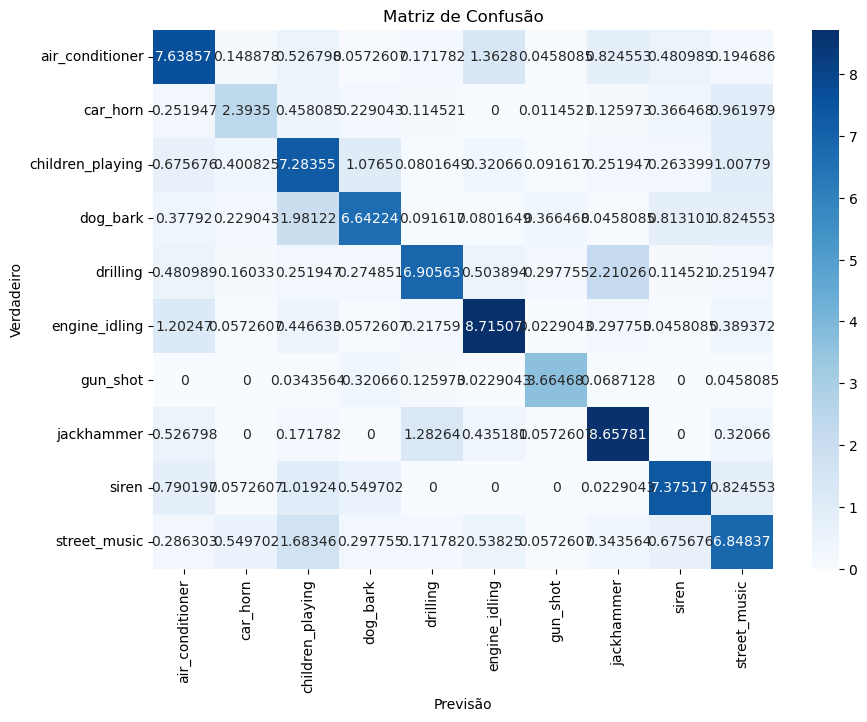

In [131]:
log_file = "accuracies_mlp"
with open(log_file, "w") as f:
    f.write(f"Best Model 10-cross-validation Metrics:\n\n")
    f.write(f"Accuracies: {best_model_accuracies}\n")
    f.write(f"Mean Accuracy: {best_model_accuracy}\n")
    f.write(f"Mean Loss: {best_model_loss}\n")
    f.write(f"Confusion Matrix:\n{best_model_cfm}\n\n")

print(best_model.summary())
print("Learning rate: ", best_model_lr)
print("Number of epochs: ", best_model_epochs)
print("Batch Size: ", best_model_batch_size)
print("Accuracy: ", best_model_accuracy)
print("Loss: ", best_model_loss)

cm = pd.DataFrame(best_model_cfm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.show()

---

## Pré processamento de dados para a Rede Neural Convolucional

#### Importação dos dados

In [ ]:
metadata_path = '/content/drive/MyDrive/Trabalho_AC2/UrbanSound8K/metadata/UrbanSound8K.csv'

metadata = pd.read_csv(metadata_path)

metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
labels = metadata['class'].unique()
print(labels)

['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']


#### Aplicação do Espectograma de Mel aos dados em áudio

Por tentativa/erro percebemos que um número de mels adequados para o tamanho dos áudios seria 32. Mais do que isso geraria filtros vazios. Para além disso, definimos a frequência máxima como o mínimo entre metade da taxa de amostragem e 8kHz para obtermos valores razoáveis

In [ ]:
def melspectrogram(file_path, target_length=376):
    audio, sr = librosa.load(file_path, sr=None)
    if audio.size == 0:
        raise ValueError(f"Arquivo de áudio vazio: {file_path}")

    fmax = min(8000, sr / 2)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=32, fmax=fmax)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    current_length = mel_spec_db.shape[-1]

    if current_length < target_length:
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, target_length - current_length)), mode='constant')
    elif current_length > target_length:
        mel_spec_db = mel_spec_db[:, :target_length]

    if np.all(mel_spec_db == 0):
        raise ValueError(f"Espectrograma vazio para o arquivo: {file_path}")

    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

    return mel_spec_db

#### Aplicação dos Coeficientes Cepstrais de Frequência de Mel aos dados em áudio

Por tentativa/erro percebemos que um número de mels adequados para o tamanho dos áudios seria 128

In [ ]:
def mfcc(file_path, target_length=376):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=2048, hop_length=512, n_mels=128)

    current_length = mfcc.shape[-1]
    if current_length < target_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, target_length - current_length)), mode='constant')
    elif current_length > target_length:
        mfcc = mfcc[:, :target_length]
    return mfcc

#### Processar e guardar todos os áudios de acordo com o tipo de input que queremos fornecer à CNN

In [ ]:
def save_input(input_audio_path, image, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    file_name = os.path.splitext(os.path.basename(input_audio_path))[0] + '.npy'
    output_path = os.path.join(output_folder, file_name)

    np.save(output_path, image)

In [ ]:
def process_fold(input_folder, output_folder, input_type):
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.wav'):
            audio_path = os.path.join(input_folder, file_name)
            if input_type == 'mfcc':
                image = mfcc(audio_path)
            elif input_type == 'melspec':
                image = melspectrogram(audio_path)

            save_input(audio_path, image, output_folder)


def process_all_folds(audio_root, input_type):
    if input_type == 'mfcc':
        processed_root = "processed_mfcc"
    elif input_type == 'melspec':
        processed_root = "processed_melspec"

    os.makedirs(processed_root, exist_ok=True)

    for fold in os.listdir(audio_root):
        fold_path = os.path.join(audio_root, fold)
        if os.path.isdir(fold_path):
            processed_fold_path = os.path.join(processed_root, fold)

            os.makedirs(processed_fold_path, exist_ok=True)

            process_fold(fold_path, processed_fold_path, input_type)

#### Criação da classe AudioDataset para facilitar a manipulação dos dados

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None, target_length=376):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.target_length = target_length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        label = self.labels[index]

        try:
            features = np.load(file_path)
        except FileNotFoundError as e:
            print(e)
            features = np.zeros((32, 376))

        features = torch.tensor(features, dtype=torch.float32).unsqueeze(0)

        if self.transform:
            features = self.transform(features)

        return features, label

#### Definição dos folds de acordo com os folds dos dados originais

Como estamos a definir os dados para a otimização bayesiana não vamos aplicar 10-cross-validation, por isso atribuimos 1 fold específico para teste, 1 fold específico para desenvolvimento e os restantes para treino

In [ ]:
folds = {i: [] for i in range(1, 11)}

for i in range(len(metadata)):
    fold_number = metadata.iloc[i]['fold']
    folds[fold_number].append(i)

def get_train_val_test_split(folds, test_fold, dev_fold):
    train_indices = []
    test_indices = folds[test_fold]
    dev_indices = folds[dev_fold]

    for fold in folds:
        if fold != test_fold and fold != dev_fold:
            train_indices.extend(folds[fold])

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_dev = X[dev_indices]
    y_dev = y[dev_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_dev = le.transform(y_dev)
    y_test = le.transform(y_test)

    return X_train, y_train, X_dev, y_dev, X_test, y_test

---

## Rede Neural Convolucional

#### Definição do modelo CNN

Após alguma pesquisa, decidimos criar um modelo com 4 camadas, uma camada convulsional, uma camada pooling e uma camada totalmente ligada. Não existe uma camada softmax para a saída pois iria interferir com o cálculo da cross-entropy-loss durante o treino. O que fizemos foi não definir a camada diretamente no modelo e depois transformar os outputs do modelo em labels "manualmente" antes de testar. O número de filtros, e de mapas de características (consequentemente) foi definido como 16 na primeira camada, uma escolha conservadora que permite ao modelo correr mais rápido, mas que desacelera um pouco o ritmo de aprendizagem.

In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self, n_mels):
        super(CNNNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Flatten()

        dummy_input = torch.randn(1, 1, n_mels, 376)
        dummy_output = self.conv1(dummy_input)
        dummy_output = self.conv2(dummy_output)
        dummy_output = self.conv3(dummy_output)
        output_size = dummy_output.numel()

        self.linear = nn.Linear(output_size, 10)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

#### Inicialização dos pesos

Inicializamos sempre os pesos do modelo com uma função gaussiana. O bias é inicializado com o valor zero

In [ ]:
def initialize_weights(layer):
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        mean = 0.0
        stddev = 0.01
        with torch.no_grad():
            layer.weight = nn.Parameter(torch.tensor(np.random.normal(loc=mean, scale=stddev, size=layer.weight.shape), dtype=torch.float32))
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

#### Otimização Bayesiana

Nesta função corre-se uma otimização bayesiana dos hiperparâmetros de learning rate e nº de epochs (decidimos por um número fixo e razoável de batch size para não prejudicar ainda mais o tempo de execução). A otimização é baseada na loss (pensámos que era a melhor métrica, visto que a accuracy sem 10-cross-validation pode ser mais enganadora). O learning rate tem um scheduler que diminui em 10% o learning rate em cada epoch (para evitar overfitting). Esta otimização executa 20 tentativas para tentar encontrar os melhores parâmetros. No fim de cada epoch utiliza o fold de desenvolvimento para melhorar o treino do modelo e no fim de cada tentativa utiliza o fold de teste para testar o modelo treinado. Retorna os parâmetros do melhor modelo para depois se executar uma 10-cross-validation do modelo com esses parâmetros

In [ ]:
def bayesian_optimization_loss(model_class, log_file, n_mels):
    batch_size = 64
    best_model = None
    best_accuracy = 0
    best_cm_percentage = None
    best_avg_test_loss = float('inf')

    with open(log_file, "w") as f:
        f.write("Resultados da Otimização Bayesiana\n\n")

    def plot_confusion_matrix(cm, trial_number):
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - Trial {trial_number}")
        plt.colorbar()
        tick_marks = np.arange(len(cm))
        plt.xticks(tick_marks, np.arange(cm.shape[1]))
        plt.yticks(tick_marks, np.arange(cm.shape[0]))

        thresh = cm.max() / 2
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, f"{cm[i, j]:.2f}%", horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix_trial_{trial_number}.png")
        plt.close()


    def objective(trial):
        nonlocal best_model, best_accuracy, best_cm_percentage, best_avg_test_loss
        lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        epochs = trial.suggest_int("epochs", 5, 30, log=True)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = model_class(n_mels)
        model.apply(initialize_weights)
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}: Training...")
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            scheduler.step()

            print(f"Epoch {epoch + 1}/{epochs}: Validation...")
            model.eval()
            dev_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    dev_loss += loss.item()

            avg_dev_loss = dev_loss / len(val_loader)
            print(f"Validation Loss: {avg_dev_loss}")

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        model.eval()
        all_labels = []
        all_predictions = []
        test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        avg_test_loss = test_loss / len(test_loader)
        cm = confusion_matrix(all_labels, all_predictions)
        cm_percentage = cm / np.sum(cm) * 100

        trial_number = trial.number

        with open(log_file, "a") as f:
            f.write(f"Trial {trial_number}\n")
            f.write(f"Learning Rate: {lr}, Epochs: {epochs}\n")
            f.write(f"Test Loss: {avg_test_loss}, Accuracy: {accuracy}\n")
            f.write(f"Confusion Matrix:\n{cm_percentage}\n\n")

        print("Teste Final após tentativa de otimização:")
        print(f"Test Loss: {avg_test_loss}")
        print(f"Accuracy: {accuracy}")
        print(f"Confusion Matrix:\n{cm_percentage}")

        plot_confusion_matrix(cm_percentage, trial_number)

        if accuracy > best_accuracy:
            best_avg_test_loss = avg_test_loss
            best_accuracy = accuracy
            best_cm_percentage = cm_percentage
            best_model = model

        return -accuracy

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=40)

    best_hyperparams = study.best_params
    best_learning_rate = best_hyperparams["learning_rate"]
    best_epochs = best_hyperparams["epochs"]

    return best_model, best_accuracy, best_cm_percentage, best_avg_test_loss, best_learning_rate, best_epochs

#### Treino e teste do modelo com os melhores hiperparâmetros utilizando 10-cross-validation

In [ ]:
def cross_validation (model_class, lr, epochs, num_folds, log_file, n_mels):
    num_folds = 10
    all_accuracies = []
    all_confusion_matrices = []
    all_losses = []
    batch_size = 64
    kfold = list(range(num_folds))
    all_results = []

    with open(log_file, "w") as f:
        f.write("Best Model 10-cross-validation metrics\n\n")

    for test_fold in kfold:
        dev_fold = (test_fold + 1) % num_folds
        train_folds = [fold for fold in kfold if fold != test_fold and fold != dev_fold]

        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False
        )

        print(f"Test fold: {test_fold}, Validation fold: {dev_fold}")

        model = model_class(n_mels)
        model.apply(initialize_weights)
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}: Training...")
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            scheduler.step()

            print(f"Epoch {epoch + 1}/{epochs}: Validation...")
            model.eval()
            dev_loss = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    dev_loss += loss.item()

            avg_dev_loss = dev_loss / len(val_loader)
            print(f"Validation Loss: {avg_dev_loss}")

        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        model.eval()
        all_labels = []
        all_predictions = []
        test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_predictions)
        avg_test_loss = test_loss / len(test_loader)
        cm = confusion_matrix(all_labels, all_predictions)
        cm_percentage = cm / np.sum(cm) * 100

        with open(log_file, "a") as f:
            f.write(f"Fold {test_fold}\n")
            f.write(f"Test Loss: {avg_test_loss}"),
            f.write(f"Accuracy: {accuracy}\n")
            f.write(f"Confusion Matrix:\n{cm_percentage}\n\n")

        all_accuracies.append(accuracy)
        all_confusion_matrices.append(cm_percentage)
        all_losses.append(avg_test_loss)
        print(f"Accuracy: {accuracy}")

    print(f"Accuracy: {np.mean(all_accuracies)}")
    print(f"Confusion Matrix: {np.sum(all_confusion_matrices, axis=0)}")
    mean_loss = (f"Loss: {np.mean(all_losses)}")

#### Treino e teste da CNN com input do tipo Spectograma de Mel


In [ ]:
audio_root = '/content/drive/MyDrive/Trabalho_AC2/UrbanSound8K/audio'
input_type = 'melspec'
process_all_folds(audio_root, input_type)

In [ ]:
base_path = 'processed_melspec'

metadata['slice_file_name'] = metadata['slice_file_name'].str.replace('.wav', '.npy')
metadata['file_path'] = metadata.apply(lambda row: os.path.join(base_path, f'fold{row["fold"]}', row['slice_file_name']), axis=1)

X = metadata['file_path'].values
y = metadata['classID'].values

In [ ]:
X_train, y_train, X_val, y_dev, X_test, y_test = get_train_val_test_split(folds, test_fold=1, dev_fold=2)
train_dataset = AudioDataset(file_paths=X_train, labels=y_train)
val_dataset = AudioDataset(file_paths=X_val, labels=y_dev)
test_dataset = AudioDataset(file_paths=X_test, labels=y_test)
data, label = train_dataset[0]

In [ ]:
log_file = "optimization_results_CNN_melspec.txt"
best_model, best_model_accuracy, best_model_cfm, best_model_loss, best_model_lr, best_model_epochs = bayesian_optimization_loss(CNNNetwork, log_file, 32)

with open(log_file, "a") as f:
    f.write(f"Best Model Learning Rate: {best_model_lr}")
    f.write(f"Best Model Epochs: {best_model_epochs}")
    f.write(f"Best Model Accuracy: {best_model_accuracy}")
    f.write(f"Best Model Confusion Matrix Percentage:\n{best_model_cfm}")
    f.write(f"Best Model Loss: {best_model_loss}")

print(f"Best Model Learning Rate: {best_model_lr}\n")
print(f"Best Model Epochs: {best_model_epochs}\n")
print(f"Best Model Accuracy: {best_model_accuracy}\n")
print(f"Best Model Confusion Matrix Percentage:\n{best_model_cfm}")
print(f"Best Model Loss: {best_model_loss}\n")

log_file = "accuracies_CNN_melspec"
cross_validation(CNNNetwork, best_model_lr, best_model_epochs, 10, log_file, 32)

In [ ]:
log_file = "accuracies_CNN_melspec"
best_model_lr = 0.00015606527934037734
best_model_epochs = 6
cross_validation(CNNNetwork, best_model_lr, best_model_epochs, 10, log_file, 32)

#### Treino e teste da CNN com input do tipo MFCC

In [ ]:
audio_root = '/content/drive/MyDrive/Trabalho_AC2/UrbanSound8K/audio'
input_type = 'mfcc'
process_all_folds(audio_root, input_type)

In [ ]:
base_path = 'processed_mfcc' # Alterar de acordo com o input desejado

metadata['slice_file_name'] = metadata['slice_file_name'].str.replace('.wav', '.npy')
metadata['file_path'] = metadata.apply(lambda row: os.path.join(base_path, f'fold{row["fold"]}', row['slice_file_name']), axis=1)

X = metadata['file_path'].values
y = metadata['classID'].values

print(X[:5])

In [ ]:
X_train, y_train, X_val, y_dev, X_test, y_test = get_train_val_test_split(folds, test_fold=1, dev_fold=2)
train_dataset = AudioDataset(file_paths=X_train, labels=y_train)
val_dataset = AudioDataset(file_paths=X_val, labels=y_dev)
test_dataset = AudioDataset(file_paths=X_test, labels=y_test)
data, label = train_dataset[0]

In [ ]:
log_file = "optimization_results_CNN_mfcc.txt"
best_model, best_model_accuracy, best_model_cfm, best_model_loss, best_model_lr, best_model_epochs = bayesian_optimization_loss(CNNNetwork, log_file, 128)

with open(log_file, "a") as f:
    f.write(f"Best Model Learning Rate: {best_model_lr}")
    f.write(f"Best Model Epochs: {best_model_epochs}")
    f.write(f"Best Model Accuracy: {best_model_accuracy}")
    f.write(f"Best Model Confusion Matrix Percentage:\n{best_model_cfm}")
    f.write(f"Best Model Loss: {best_model_loss}")

print(f"Best Model Learning Rate: {best_model_lr}\n")
print(f"Best Model Epochs: {best_model_epochs}\n")
print(f"Best Model Accuracy: {best_model_accuracy}\n")
print(f"Best Model Confusion Matrix Percentage:\n{best_model_cfm}")
print(f"Best Model Loss: {best_model_loss}\n")

log_file = accuracies = "accuracies_CNN_mfcc"
cross_validation(CNNNetwork, best_model_lr, best_model_epochs, 10, log_file, 128)

In [ ]:
log_file = "accuracies_CNN_mfcc"
best_model_lr = 0.00015606527934037734
best_model_epochs = 6
cross_validation(CNNNetwork, best_model_lr, best_model_epochs, 10, log_file, 128)

## Comparação de modelos

#### Friedman Test  
Realizámos um Friedman Test para comparar os 3 modelos e perceber se existiam diferenças significativas entre eles a um nível de significância de alpha = 0.05

In [140]:
MLP = [0.6227477192878723, 0.6832432150840759, 0.6727272868156433, 0.7168803215026855, 0.6281895637512207, 0.6479713320732117, 0.5843672752380371, 0.6899510025978088, 0.6463560461997986, 0.7067583203315735]
CNN_melspec = [0.5120274914089347, 0.5509736540664376, 0.5269186712485682, 0.5189003436426117, 0.5337915234822451, 0.5532646048109966, 0.5051546391752577, 0.563573883161512, 0.5589919816723941, 0.5486827033218786]
CNN_mfcc = [0.5418098510882016, 0.5372279495990836, 0.561282932416953, 0.565864833906071, 0.586483390607102, 0.54524627720504, 0.5246277205040092, 0.5498281786941581, 0.5108820160366552, 0.5360824742268041]

data = np.array([MLP, CNN_melspec, CNN_mfcc])

stat, p_value = friedmanchisquare(*data)

print(f"Friedman Test Statistic: {stat}")
print(f"P-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Significant differences exist among the models.")
else:
    print("No significant differences were found among the models.")


Friedman Test Statistic: 15.0
P-value: 0.0005530843701478337
Significant differences exist among the models.


## Nemenyi Test
Tendo em conta o resultado do Friedman Test realizámos um Nemenyi Test para perceber exatamente entre que modelos é que existiam as diferenças mais significativas

In [143]:
data = data.T
nemenyi_results = sp.posthoc_nemenyi_friedman(data)
print("Nemenyi Test Results:")
print(nemenyi_results)

Nemenyi Test Results:
          0         1         2
0  1.000000  0.002296  0.002296
1  0.002296  1.000000  1.000000
2  0.002296  1.000000  1.000000


---

## Conclusões

Começando pelo modelo MultiLayer Perceptron (MLP), que foi de longe o melhor modelo, como podemos ver pelos testes de comparação, e onde conseguimos obter resultados razoáveis. O modelo teve uma média de accuracy de 66% (com 10-cross-validation), com a accuracy bem distribuída por todas as classes, o que também é um ponto positivo. Apesar de não constar no notebook, nós experimentámos com uma divisão de folds aleatória, que nos deu 74% de accuracy, mas com uma accuracy muito alta para certas classes e muito baixa para outras, o que não era o objetivo do trabalho. Tendo em conta que o modelo rodava relativamente depressa experimentámos várias arquiteturas, com 2 ou 3 camadas escondidadas, pois queríamos testar se 2 camadas seria muito simples ou 3 seriam muito complexas e levaria a overfitting (confirmou-se a última opção), e com funções de ativação nas camadas escondidas ReLU ou LeakyReLU, pois suspeitámos que a função ReLU poderia ter um problema de dying ReLU com este dataset, o que se veio a confirmar pelos resultados. Para além disso fizemos um Grid Search que otimizou o tamanho do batch, o learning rate inicial e o número de epochs no treino.  
Passando ao modelo de Convulsion Neural Networks (CNN), que teve piores resultados que o MLP nas duas versões de input que testámos, mas não houve diferenças significativas de performance entres essas mesmas versões, como podemos ver pelos testes de comparação. A sua performance teve resultados medianos (53 e 54% de accuracy) mas que estão dentro do expectável para o comportamento de CNN's ara estes dados (a literatura fala numa accuracy expectável entre 50 a 70%).  
Em relação aos aspetos a melhorar, sabemos que existem vários, nomeadamente no grid search/otimização bayseana e na extração de features para a MLP. Poderiam haver mais hiperparâmetros a ser afinados e dentro desses hiperparâmetros mais valores possíveis (no caso do grid search) ou um maior range (no caso da otimização bayseana). Para além disso, na otimização bayseana deveriam ter havido mais tentativas (as que definimos são um valor mínimo para obter resultados razoáveis).  Na extração de features, poderia ter sido utilizada uma rede neuronal para obter mais parâmetros do que aqueles que foram obtidos (utilizando, por exemplo, transfer learning).  
Em conclusão, pensamos que conseguimos realizar todos os objetivos do trabalho, especialmente tendo em conta a limitação do poder computacional das máquinas utilizadas, e que os resultados obtidos foram razoáveis e dentro do expectável.

---


## Referências


https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c
https://medium.com/thedeephub/learning-rate-and-its-strategies-in-neural-network-training-270a91ea0e5c
https://www.kaggle.com/code/androbomb/simple-nn-with-python-multi-layer-perceptron
https://medium.com/ensina-ai/rede-neural-perceptron-multicamadas-f9de8471f1a9
https://iaexpert.academy/2020/05/04/quantas-camadas-escondidas-e-quantos-neuronios-incluir-numa-rede-neural-artificial/ https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c
https://github.com/enochkan/building-from-scratch/blob/main/optimizers/adam-optimizer-from-scratch.ipynb
https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/
https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab
https://stackoverflow.com/questions/60390707/how-to-choose-the-number-of-convolution-layers-and-filters-in-cnn
https://machinelearningmastery.com/improve-deep-learning-performance/
https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939  
https://www.geeksforgeeks.org/how-to-decide-number-of-filters-in-cnn/  
https://www.sciencedirect.com/topics/earth-and-planetary-sciences/bayesian-optimization
https://www.youtube.com/watch?v=SQ1iIKs190Q&t=931s
https://librosa.org/doc/main/feature.html
https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab
